### Importing modules

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import time
import itertools
import pickle
import os

from IPython.display import clear_output

from sklearn.metrics import confusion_matrix , classification_report, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import KFold

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D , MaxPooling2D , Dense , BatchNormalization , Dropout,Flatten , Activation
from tensorflow.keras import regularizers

import tensorflow_addons as tfa

from tensorflow import keras
from keras.applications.vgg19 import VGG19
from keras.applications import ResNet50V2
from keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dropout
from keras.optimizers import Adam
from keras.models import Sequential
from keras.callbacks import EarlyStopping, ReduceLROnPlateau


sns.set_style('whitegrid')
import warnings
warnings.filterwarnings('ignore')

### Constants

In [8]:
# DIRECTORIES

DATASET = []
DATASET.append("./dataset1/brain_tumor_dataset_pp")
DATASET.append("./dataset2/Brain Tumor Data Set/Brain Tumor Data Set_pp006")

DATASET_PP = []
TRAIN_PATH = []
TEST_PATH = []
CLASS_LABELS = []
NUM_OF_CLASSES = []

for ii, ds in enumerate(DATASET):
    DATASET_PP.append(ds)
    TRAIN_PATH.append(ds + "/Train")
    TEST_PATH.append(ds + "/Test")
    CLASS_LABELS.append([filename for filename in os.listdir(TRAIN_PATH[ii]) if os.path.isdir(os.path.join(TRAIN_PATH[ii], filename))])
    
    NUM_OF_CLASSES.append(len(CLASS_LABELS[ii]))


# OTHER
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

In [4]:
try_r_seeds = [42, 123, 82]
try_optimizers = ['adam', 'sgd', "adagrad"]
try_ds = [0, 1]
try_kernels = [3,5]
try_layers = [3,4,5]
try_folds = [None]

In [6]:
combos = list(itertools.product(try_r_seeds, try_optimizers, try_ds, try_kernels, try_layers, try_folds))

# Now all_combinations contains all possible combinations of the lists
print(f"Number of Hyperparameter combinations to by : {len(combos)}")

Number of Hyperparameter combinations to by : 108


## Function Definitions

### Data Augmentation

In [7]:
def data_augmentation(r, s):
    # here we will define just the ImageDataGenrator
    # with 0 as the validation split to keep all the images of the traindataset
    # as currently in the train directory
    # we will split this to train-validation sets within the KFold loop

    random.seed(r)

    trn_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=s,
        rotation_range=20,          # randomly rotate the images by 20 degrees
        zoom_range=0.2,             # randomly zoom in/out on the images by 20%
        horizontal_flip=True,       # randomly flip the images horizontally
        vertical_flip=False,        # don't flip the images vertically
        width_shift_range=0.1,      # randomly shift the images horizontally by 10%
        height_shift_range=0.1,     # randomly shift the images vertically by 10%
        shear_range=0.1,            # apply random shear transformations
        fill_mode='nearest'         # fill in any empty pixels with the nearest available pixel
        )
    
    return trn_datagen

In [8]:
def test_data(tst_path, idx, img_size, batch_size):
    # and we can also define the test generator

    tst_datagen = ImageDataGenerator(rescale=1./255)


    tst_generator = tst_datagen.flow_from_directory(tst_path[idx],
                                                    target_size=img_size,
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=False)
    return tst_generator

In [9]:
def plot_train_history(h, save2f = ''):
    
    hm=['loss', 'accuracy', 'f1_score', 'val_loss', 'val_accuracy', 'val_f1_score']
    e = len(h.history['loss'])

    # Plot metric values for the current seed
    plt.figure(figsize=(12, 6))

    for i in range(6):
        plt.subplot(2, 3, i+1)
        plt.plot(range(1, e+1), h.history[hm[i]], label=hm[i])
        plt.title(hm[i])
        plt.xticks([])
        
        
    plt.tight_layout()
    
    if save2f != '':
        plt.savefig("outputs/" + save2f + ".png")

    plt.show()

In [10]:
def string_to_int(my_seed):
    
    if isinstance(my_seed, str):
        ascii_values = 0
        for char in my_seed:
            ascii_values += ord(char)
        return int(ascii_values)
    else:
        return my_seed

# Transfer Learning

## Base Model : ResNet50v2

### Model definition

In [80]:
def my_ResNet_model(c, show_summary=False):
    tf.keras.backend.clear_session()

    base_model = ResNet50V2(input_shape=IMG_SIZE+(3,), include_top=False)
    base_model.trainable = False

    mymodel = Sequential([base_model, 
                          GlobalAveragePooling2D(),
                          Flatten(),
                          Dense(256, activation="relu", kernel_initializer='he_normal'),
                          Dropout(0.3),
                          Dense(c, activation='softmax')
                          ])

    mymodel.compile(optimizer=Adam(), 
                    loss='categorical_crossentropy', 
                    metrics=['accuracy',
                             tf.keras.metrics.Precision(),
                             tf.keras.metrics.Recall(),
                             tf.keras.metrics.AUC(),
                             tfa.metrics.F1Score(num_classes=c, average='macro')
                             ])
    
    if show_summary:
        mymodel.summary()
    
    return mymodel

In [81]:
# show an example of a model summary for 2 classes
my_ResNet_model(2, show_summary=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 514       
                                                        

## Base Model : VGG19

### Model definition

In [11]:
def my_VGG19_model(c, show_summary=False):
    tf.keras.backend.clear_session()

    base_model = VGG19(weights='imagenet', include_top=False,
                       input_shape=IMG_SIZE+(3,))

    base_model.trainable = False

    mymodel = Sequential([base_model,
                          GlobalAveragePooling2D(),
                          Flatten(),
                          Dense(256, activation="relu", kernel_initializer='he_normal'),
                          Dropout(0.3),
                          Dense(c, activation='softmax')
                          ])
    
    mymodel.compile(optimizer=Adam(), 
                loss='categorical_crossentropy', 
                metrics=['accuracy',
                            tf.keras.metrics.Precision(),
                            tf.keras.metrics.Recall(),
                            tf.keras.metrics.AUC(),
                            tfa.metrics.F1Score(num_classes=c, average='macro')
                            ])
    
    if show_summary:
        mymodel.summary()
    
    return mymodel

In [83]:
# show an example of a model summary for 2 classes
my_VGG19_model(2, show_summary=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 514       
                                                        

# Custom CNN

### Model definition

In [12]:
def create_custom_cnn(num_layers, model_optimizer, k, imsize, n_cl, show_summary=False):
    # num_layers        : Number of layers,
    # k                 : kernel size = (k, k)

    tf.keras.backend.clear_session()
    
    if num_layers < 3 or num_layers > 5:
        raise ValueError("Number of layers must be between 3 and 5.")

    m = Sequential()
    
    m.add(Conv2D(32, (k, k), activation='relu', input_shape = imsize+(3,)))
    m.add(MaxPooling2D((2, 2)))

    for layer_idx in np.arange(2,num_layers+1,1):
        num_filters = 2**(4+layer_idx)
        m.add(Conv2D(num_filters, (k, k), activation='relu'))
        m.add(MaxPooling2D((2, 2)))

    m.add(Flatten())

    # Add fully connected layers
    m.add(Dense(256, activation='relu'))
    m.add(Dropout(0.3))
    m.add(Dense(n_cl, activation='softmax'))

    #plot_model(m, show_shapes=True, show_layer_names=True)             # doesn't work locally

    m.compile(optimizer=model_optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy',
              tf.keras.metrics.Precision(),
              tf.keras.metrics.Recall(),
              tf.keras.metrics.AUC(),
              tfa.metrics.F1Score(num_classes = n_cl, average='macro')])
    
    if show_summary:
        m.summary()

    return m

In [14]:
# show an example of a model summary for 2 classes
create_custom_cnn(5, 'adam', 7, IMG_SIZE, 2, show_summary=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 218, 218, 32)      4736      
                                                                 
 max_pooling2d (MaxPooling2  (None, 109, 109, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 103, 103, 64)      100416    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 51, 51, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 128)       401536    
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 22, 22, 128)       0

### Model training for different combos

In [16]:
test_datagen = ImageDataGenerator(rescale=1./255);

results_df = pd.DataFrame(columns=['Seed', 'Optimizer', 'Dataset', 'kernel size', 'Layers', 'Folds', 
                                   'history',
                                   'elapsed time',
                                   'test_loss',
                                   'test_accuracy',
                                   'test_precision',
                                   'test_recall',
                                   'test_auc',
                                   'test_f1_score'])

for ii, combo in enumerate(combos):

    this_r_seed, this_optimizer, this_ds, this_kernel, this_layer, this_fold  = combo

    start_time = time.time()

    random.seed(this_r_seed)
        
    print("\n\n################################################################################")
    print(f"combination : {ii+1} of {len(combos)}")
    print(f"Seed : {this_r_seed}, Optimizer : {this_optimizer}, DS : {this_ds}, kernel = {this_kernel}x{this_kernel},  Layers = {this_layer}, folds = {this_fold}")
                  
    print(f"\n----------------------------------------------------------------- (Train, Val)")

    train_datagen = data_augmentation(this_r_seed, 0.2)

    train_generator = train_datagen.flow_from_directory(TRAIN_PATH[this_ds],
                                                        target_size=IMG_SIZE,
                                                        batch_size=BATCH_SIZE,
                                                        class_mode='categorical',
                                                        shuffle=True,
                                                        subset='training'
                                                        )

    val_generator = train_datagen.flow_from_directory(TRAIN_PATH[this_ds],
                                                    target_size=IMG_SIZE,
                                                    batch_size=BATCH_SIZE,
                                                    class_mode='categorical',
                                                    shuffle=False,
                                                    subset='validation'
                                                    )
    test_generator = test_datagen.flow_from_directory(TEST_PATH[this_ds],
                                                target_size=IMG_SIZE,
                                                batch_size=BATCH_SIZE,
                                                class_mode='categorical',
                                                shuffle=False)

    
    es = EarlyStopping(monitor="val_accuracy", 
                mode="max",
                restore_best_weights=True,
                patience=6)
    
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='accuracy', factor=0.3, patience=2, min_lr=0.0000001)

    print(f"\n----------------------------------------------------------------- Training")
        
    int_seed = string_to_int(this_r_seed)
    np.random.seed(string_to_int(int_seed))
    tf.random.set_seed(int_seed)

    model = create_custom_cnn(this_layer, this_optimizer, this_kernel, IMG_SIZE, NUM_OF_CLASSES[this_ds])

    # for fold, (train_indices, val_indices) in enumerate(kf.split(all_train_generator.filepaths, all_train_generator.classes)):
    #     if fold == 0:
    #         z1 = np.array(all_train_generator.filepaths)[train_indices]
    #         print(len(z1))
    #         z2 = np.array(all_train_generator.filepaths)[val_indices]
    #         print(len(z2))
    #         print(len(z1)+len(z2))
    #         print("........")


    hist = model.fit(train_generator,
                    epochs=30,
                    validation_data=val_generator,
                    callbacks=[es, reduce_lr]
                    )

    end_time = time.time()
    elapsed_time = end_time - start_time

    print(f"\n----------------------------------------------------------------- Evaluation")

    this_result = model.evaluate(test_generator);
    
    new_row = [this_r_seed, this_optimizer, os.path.basename(DATASET[this_ds]), this_kernel, this_layer, this_fold] + [hist.history, int(elapsed_time+0.5)] + this_result


    results_df.loc[len(results_df)] = new_row
    results_df.reset_index(drop=True, inplace=True)

    clear_output()
   
    


In [19]:
import winsound

# Frequency and duration of the beep (in milliseconds)
frequency = 1000  # You can change this to set the frequency of the beep
duration = 2000  # You can change this to set the duration of the beep

winsound.Beep(frequency, duration)


# Explore Results

### 20 best combinations in terms of test_accuracy

In [37]:
top = results_df.sort_values(by='test_accuracy', ascending=False)
top20 = top[['Seed','Dataset', 'Optimizer', "Layers", "kernel size", "test_accuracy"]].head(20)
top20

,Seed,Dataset,Optimizer,Layers,kernel size,test_accuracy
74,82,brain_tumor_dataset_pp,adam,5,3,0.829787
73,82,brain_tumor_dataset_pp,adam,4,3,0.829787
1,42,brain_tumor_dataset_pp,adam,4,3,0.787234
72,82,brain_tumor_dataset_pp,adam,3,3,0.787234
38,123,brain_tumor_dataset_pp,adam,5,3,0.787234
37,123,brain_tumor_dataset_pp,adam,4,3,0.765957
3,42,brain_tumor_dataset_pp,adam,3,5,0.765957
36,123,brain_tumor_dataset_pp,adam,3,3,0.744681
78,82,Brain Tumor Data Set_pp006,adam,3,3,0.714286
15,42,brain_tumor_dataset_pp,sgd,3,5,0.702128


### Average Test Accuracies by parameter

adam seems to perform the best

In [35]:
df = results_df.groupby('Optimizer')['test_accuracy'].mean().reset_index()
df

,Optimizer,test_accuracy
0,adagrad,0.597976
1,adam,0.644003
2,sgd,0.606226


number of layers and kernel size impact on accuracy doesn't seem to be that significant

In [34]:
df = results_df.groupby('Layers')['test_accuracy'].mean().reset_index()
df

,Layers,test_accuracy
0,3,0.624306
1,4,0.616177
2,5,0.607722


In [36]:
df = results_df.groupby('kernel size')['test_accuracy'].mean().reset_index()
df

,kernel size,test_accuracy
0,3,0.620696
1,5,0.611441


## Plot Specific History based on combination of parameters

In [ ]:
plot_ds = [0, 1]
plot_optimizers = 'adam'
plot_kernels = 3
plot_layers = 4
try_folds = None

In [11]:
plot_ds = os.path.basename(DATASET[0])
plot_optimizer = 'adam'
plot_kernel = 3
plot_layer = 4

flt = [['Dataset', plot_ds],
       ['Optimizer', plot_optimizer],
       ['kernel size', plot_kernel],
       ['Layers',plot_layer]
       ] 

fltv = np.full(len(results_df), True, dtype=bool)

for f in flt:
    fltv = fltv & np.array(results_df[f[0]]==f[1]) 

filterd_results_df = results_df[fltv]

In [12]:
filterd_results_df

,Seed,Optimizer,Dataset,kernel size,Layers,Folds,history,elapsed time,test_loss,test_accuracy,test_precision,test_recall,test_auc,test_f1_score
1,42,adam,brain_tumor_dataset_pp,3,4,None,"{'loss': [0.8353332281112671, 0.68417775630950...",63,0.523824,0.787234,0.787234,0.787234,0.826618,0.745671
37,123,adam,brain_tumor_dataset_pp,3,4,None,"{'loss': [1.0955568552017212, 0.68054211139678...",48,0.673095,0.765957,0.765957,0.765957,0.828203,0.743169
73,82,adam,brain_tumor_dataset_pp,3,4,None,"{'loss': [1.2691019773483276, 0.65158969163894...",53,0.455686,0.829787,0.829787,0.829787,0.870077,0.804167


Seed : 42


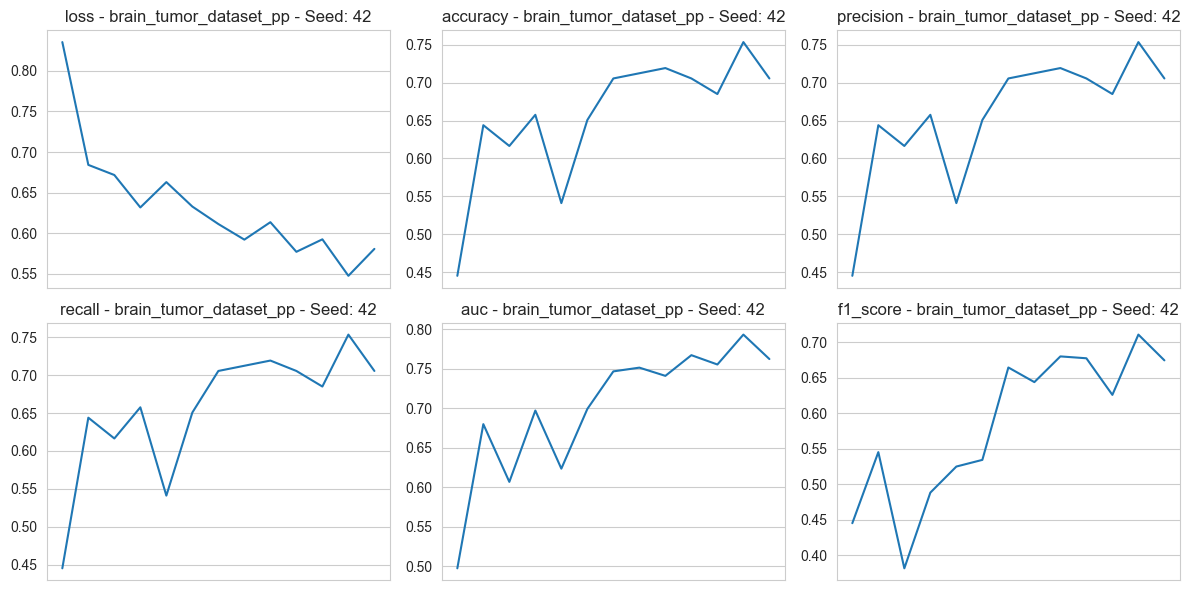

Seed : 123


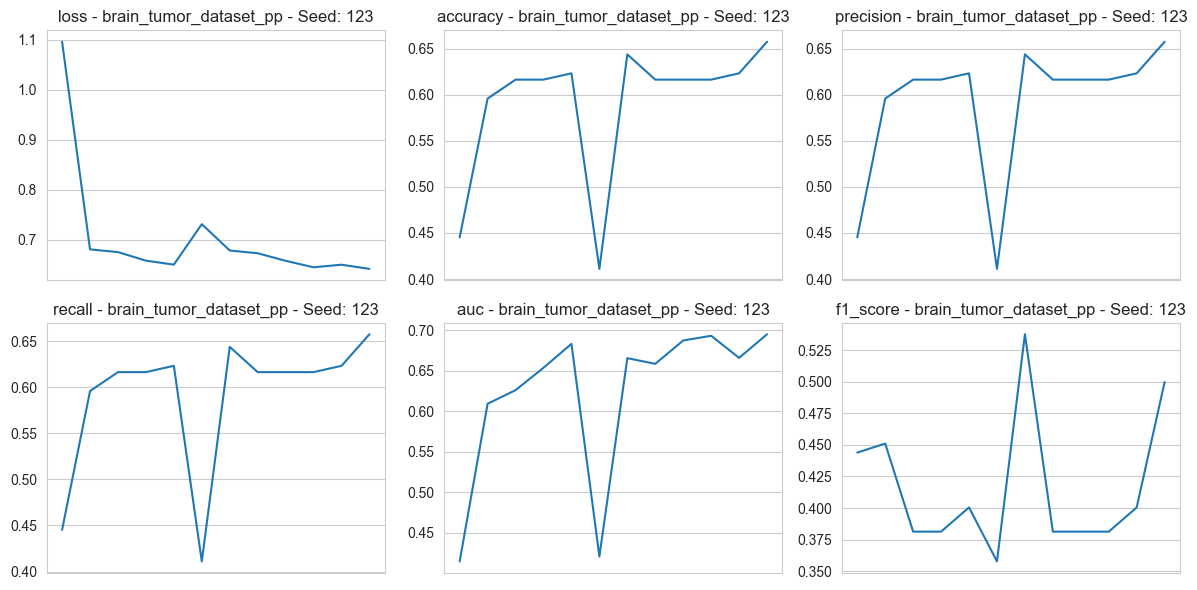

Seed : 82


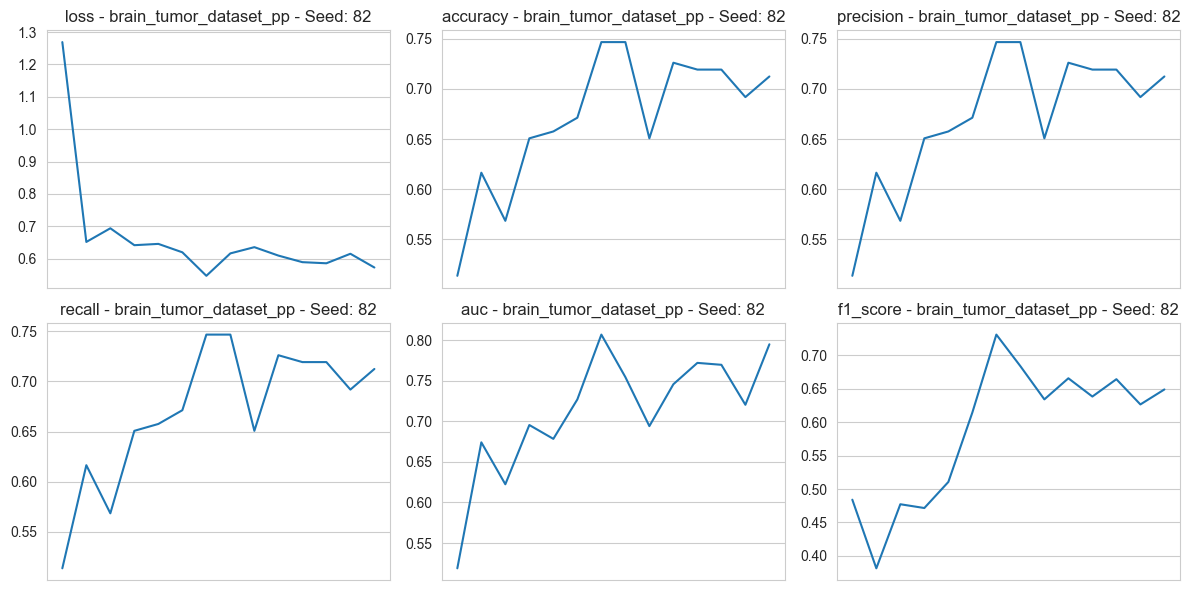

In [13]:
for index, row in filterd_results_df.iterrows():
    print(f"Seed : {row['Seed']}")

    h = row['history']
    hds = row['Dataset']
    e = len(h['loss'])

    hk = list(h.keys())

    plt.figure(figsize=(12, 6))

    for i in range(6):
        # print(h[hk[i]])
        plt.subplot(2, 3, i+1)
        plt.plot(range(1, e+1), h[hk[i]], label=hk[i])
        plt.title(f"{hk[i]} - {hds} - Seed: {row['Seed']}")
        plt.xticks([])
        plt.tight_layout()
        
    plt.show()

# END